# Implementation of the ER (Event Rejection) algorithm for four-jet signatures

In [1]:
from h5py import File
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import norm
import random
import itertools as it
import time
import joblib

In [4]:
#Opening the HDF5 File
input_file = "../data22_13p6TeV.00440499.physics_EnhancedBias.h5"
#input_file = "../EBdata.h5"
#input_file = "../hh4b.h5"
#input_file = "../jz0.h5"
#input_file = "../jz1.h5"
#input_file = "../jz2.h5"
#input_file = "../jz3.h5"
#input_file = "../jz4.h5"
#input_file = "../jz5.h5"

data = File(input_file, 'r')
print("List of available datasets: " + str(list(data.keys())))

List of available datasets: ['jets']


In [5]:
#Accessing the 'Jets' Dataset
jets = data['jets']
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))
print("The shape of the dataset is: " + str(jets.shape))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'fastGN120230327_pb', 'fastGN120230327_pc', 'fastGN120230327_pu', 'dipz20230223_z', 'dipz20230223_negLogSigma2', 'jetPtRank', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexBeamspotZ', 'primaryVertexDetectorZUncertainty'])
The shape of the dataset is: (22136,)


In [6]:
print("The number of jets in the sample is: " + str(len(jets)))
print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20])))
print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))

The number of jets in the sample is: 22136
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0


In [7]:
#Getting the events in our sample
uniques = np.unique(jets["eventNumber"])
print("The number of events in our sample is: " + str(len(uniques)))
print("The events_ID array looks like: " + str(uniques))

The number of events in our sample is: 6253
The events_ID array looks like: [1117958940 1117959114 1117959199 ... 1144345763 1144346688 1144349488]


In [8]:
%%time
# Getting an array of the jet multiplicities in the sample
jet_multiplicities = []
for i in uniques:
    jet_multiplicities.append(len(jets[jets["eventNumber"] == i]))

CPU times: user 35.3 s, sys: 346 ms, total: 35.6 s
Wall time: 35.8 s


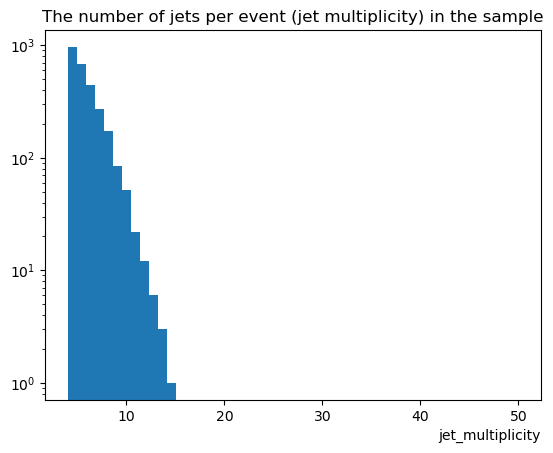

In [9]:
# Plotting the jet multiplicities in the sample
plt.hist(jet_multiplicities, bins = 50, range=(4,50))
plt.yscale('log')
plt.xlabel("jet_multiplicity", loc='right')
plt.title('The number of jets per event (jet multiplicity) in the sample')
plt.show()

In [10]:
%%time
# Getting an array of the leading jet pT's per event in the sample
leading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    leading_pT.append(max(pTs))

CPU times: user 35.2 s, sys: 396 ms, total: 35.6 s
Wall time: 35.7 s


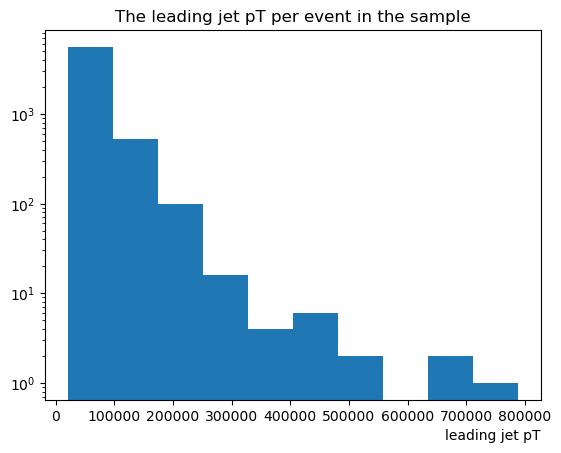

In [11]:
# Plotting the leading jet pT's per event in the sample
plt.hist(leading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("leading jet pT", loc='right')
plt.title('The leading jet pT per event in the sample')
plt.show()

In [12]:
%%time
# Getting an array of the sub-leading jet pT's per event in the sample
subleading_pT = []
for i in uniques:
    pTs = []
    event_jets = jets[jets["eventNumber"] == i]
    for jet in event_jets:
        pTs.append(jet["pt"])
    if len(pTs) > 1: 
        subleading_pT.append(sorted(pTs)[-2])

CPU times: user 35.3 s, sys: 308 ms, total: 35.6 s
Wall time: 35.7 s


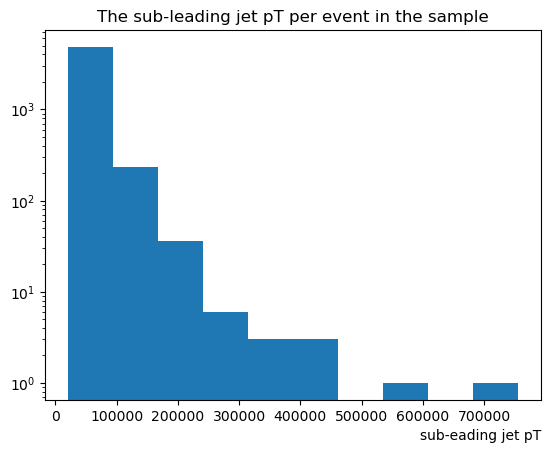

In [13]:
# Plotting the sub-leading jet pT's per event in the sample
plt.hist(subleading_pT, bins = 10)
plt.yscale('log')
plt.xlabel("sub-eading jet pT", loc='right')
plt.title('The sub-leading jet pT per event in the sample')
plt.show()

In [14]:
%%time

#Filtering the four-or-more jet events
fom_events = []
counter = 0

for id in uniques:
    if len(jets[jets["eventNumber"] == id]) >= 4:
        fom_events.append(id)
        counter +=1
    #if counter == 10000:
        #break

print("The number of events that have four or more (fom) selected jets is: " + str(len(fom_events)))

The number of events that have four or more (fom) selected jets is: 2727
CPU times: user 35.2 s, sys: 488 ms, total: 35.6 s
Wall time: 35.7 s


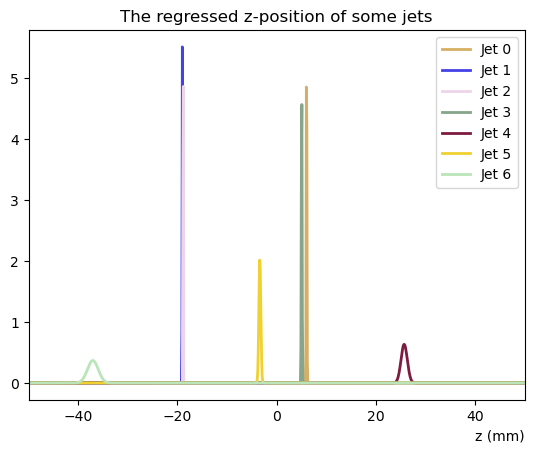

In [15]:
# Visualizing the jets in one event
event_id = fom_events[1]
event_jets = jets[jets["eventNumber"] == event_id]
num_jets = len(event_jets)

#Generating random colors for  the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(num_jets)]
ic = 0      #color counter
x = np.arange(-4*50, 4*50, 0.1)

for i in range(num_jets):
    #plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"], np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    plt.plot(x, norm.pdf(x, event_jets[i]["dipz20230223_z"]*50, np.exp(-0.5*event_jets[i]["dipz20230223_negLogSigma2"])), color=color[ic], linewidth=2, label='Jet '+str(ic))
    ic = ic + 1    
plt.xlabel("z (mm)", loc='right')
plt.title('The regressed z-position of some jets')
plt.xlim([-1*50, 1*50])
plt.legend()
plt.show()
#plt.cla()

In [16]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event NUMERICALLY

def get_max_log_likelihood_num(event_id,jets):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    z = np.arange(-5*50, 5*50, 0.1)

    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        log_total_likelihood = -4 * np.log(np.sqrt(2*np.pi))
            
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) *50
            #likelihood = (2*np.pi)**(-1/2) * (sigma)**(-1) * np.exp( -1 * (z - mu)**2 * (2 * sigma^2)**(-1) )
            log_total_likelihood -= ( np.log(sigma) + (z - mu)**2 * (2 * sigma**(2))**(-1) )
    
        mlpl_array.append(max(log_total_likelihood))
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [17]:
# A function that takes in the event number and calculates the maximum over 4-jet combinations of log of the product of the 
# likelihood functions of all the jets in the event ANALYTICALLY

def get_max_log_likelihood_an(event_id,jets):
    event_jets = jets[jets["eventNumber"] == event_id]
    #num_jets = len(event_jets)
    
    combinations = []
    mlpl_array = []

    for combination in it.combinations(event_jets, 4):
        combinations.append(combination)

    for comb in combinations:
        num = 0
        denom = 0
        second_term = 0
        third_term = 0
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            num += (mu) / (sigma**2)
            denom += 1 / (sigma**2)
            second_term -= np.log(sigma)
        for jet in comb:
            mu = jet["dipz20230223_z"] * 50
            sigma = np.exp(-0.5*jet["dipz20230223_negLogSigma2"]) * 50

            third_term -= ((num / denom) - mu)**2 / (2*sigma**2) 
            
        mlpl_array.append(-4 * np.log(np.sqrt(2*np.pi)) + second_term + third_term)
            
    
    max_log_likelihood = max(mlpl_array)
        
    return max_log_likelihood

In [18]:
len(jets[jets["eventNumber"] == fom_events[1]])

7

In [19]:
%%time
get_max_log_likelihood_an(fom_events[1],jets)

CPU times: user 4.19 ms, sys: 4 ms, total: 8.19 ms
Wall time: 8.25 ms


-12.082714974668404

In [20]:
%%time
get_max_log_likelihood_num(fom_events[1],jets)

CPU times: user 17.9 ms, sys: 0 ns, total: 17.9 ms
Wall time: 17.9 ms


-12.082715273974706

In [21]:

def get_max_log_likelihood_dist(string, num=999999999999999):
    start = time.time()
    data = File(string, 'r')
    jets = data['jets']
    uniques = np.unique(jets["eventNumber"])
    
    print("The number of jets in the sample is: " + str(len(jets)))
    print("The number of jets in the sample with pT < 20 GeV is: " + str(len(jets[jets["pt"] < 20])))
    print("The number of jets in the sample with eta > 2.5 GeV is: " + str(len(jets[jets["eta"] > 2.5])))
    print("The number of events in our sample is: " + str(len(uniques)))
    
    max_log_likelihood_list = []
    no_of_processed_events = num
    counter = 0

    for id in uniques:
        if len(jets[jets["eventNumber"] == id]) >= 4:
            max_log_likelihood_list.append(get_max_log_likelihood_an(id,jets))
            counter +=1
        if counter == no_of_processed_events:
            break

    if counter == no_of_processed_events:
        print("The provided number of four or more jet events in the sample was run over and it is: " + str(num))
    if counter != no_of_processed_events:
        print("The number of four or more jet events in the sample is: " + str(counter))
        print("The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.")
    end = time.time()
    print("The time of execution of the (get_max_log_likelihood_dist) function is :", ((end-start) / 60) , "min")

    return max_log_likelihood_list

def plot_distribution(max_log_likelihood_list):
    plt.hist(max_log_likelihood_list, bins = 500)
    plt.yscale("log")
    plt.xlabel("MLPL", loc='right')
    plt.title('Distribution of the discriminant variable (MLPL)')
    plt.show()

The number of jets in the sample is: 143465
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0
The number of events in our sample is: 40832
The number of four or more jet events in the sample is: 17613
The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.
The time of execution of the (get_max_log_likelihood_dist) function is : 31.56870637734731 min


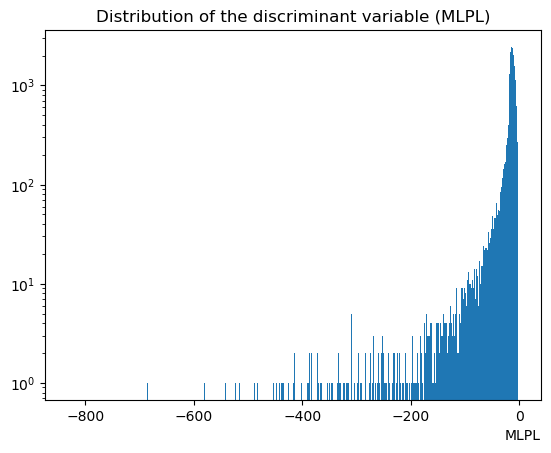

['EB_dist.sav']

In [19]:
""" Getting the distribution for the EB data sample (data22_13p6TeV:data22_13p6TeV.00440499.physics_EnhancedBias.recon.AOD.
r14725_r14726_tid33689943_00) """
EB_dist = get_max_log_likelihood_dist("../EBdata.h5", 35000)
plot_distribution(EB_dist)
joblib.dump(EB_dist, 'EB_dist.sav')

The number of jets in the sample is: 324069
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0
The number of events in our sample is: 49989
The provided number of four or more jet events in the sample was run over and it is: 35000
The time of execution of the (get_max_log_likelihood_dist) function is : 93.16382859150569 min


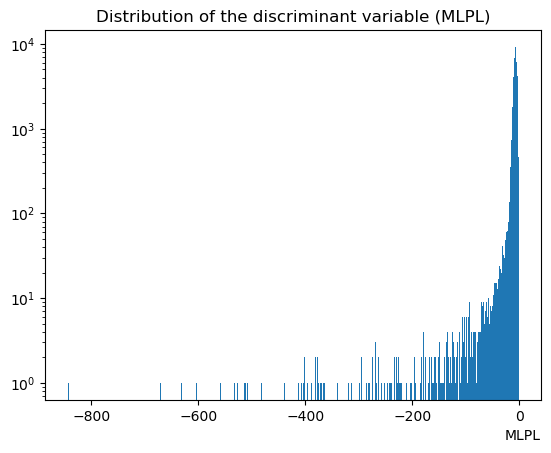

['hh4b_dist.sav']

In [20]:
hh4b_dist = get_max_log_likelihood_dist("../hh4b.h5", 35000)
plot_distribution(hh4b_dist)
joblib.dump(hh4b_dist, 'hh4b_dist.sav')

The number of jets in the sample is: 116136
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0
The number of events in our sample is: 39883
The number of four or more jet events in the sample is: 11480
The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.
The time of execution of the (get_max_log_likelihood_dist) function is : 23.06799820661545 min


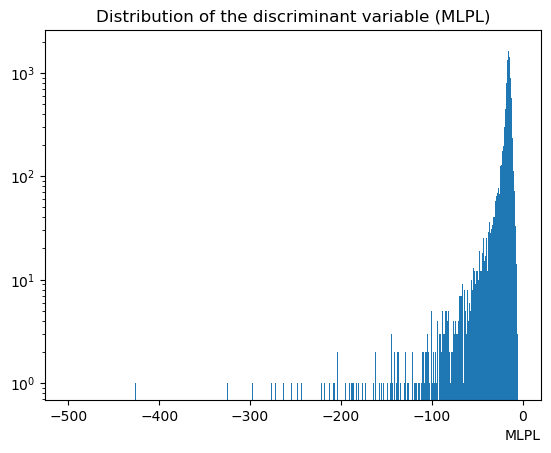

['jz0_dist.sav']

In [21]:
jz0_dist = get_max_log_likelihood_dist("../jz0.h5", 35000)
plot_distribution(jz0_dist)
joblib.dump(jz0_dist, 'jz0_dist.sav')

The number of jets in the sample is: 168465
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0
The number of events in our sample is: 46842
The number of four or more jet events in the sample is: 19947
The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.
The time of execution of the (get_max_log_likelihood_dist) function is : 43.323072679837544 min


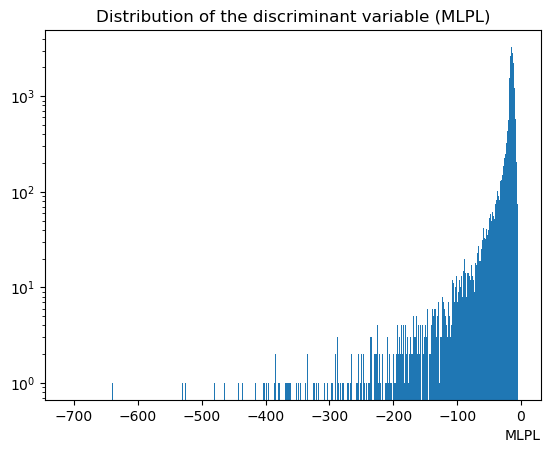

['jz1_dist.sav']

In [22]:
jz1_dist = get_max_log_likelihood_dist("../jz1.h5", 35000)
plot_distribution(jz1_dist)
joblib.dump(jz1_dist, 'jz1_dist.sav')

The number of jets in the sample is: 229572
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0
The number of events in our sample is: 49717
The number of four or more jet events in the sample is: 31744
The number of four or more jet events in the sample is less than the provided number, therefore all the sample was run over.
The time of execution of the (get_max_log_likelihood_dist) function is : 71.21941910187404 min


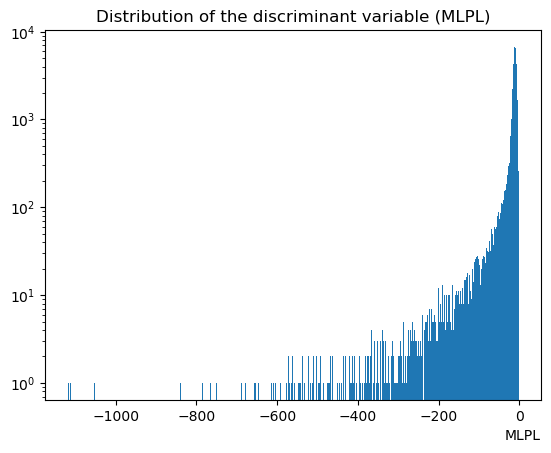

['jz2_dist.sav']

In [23]:
jz2_dist = get_max_log_likelihood_dist("../jz2.h5", 35000)
plot_distribution(jz2_dist)
joblib.dump(jz2_dist, 'jz2_dist.sav')

In [ ]:
jz3_dist = get_max_log_likelihood_dist("../jz3.h5", 35000)
plot_distribution(jz3_dist)
joblib.dump(jz3_dist, 'jz3_dist.sav')

The number of jets in the sample is: 279265
The number of jets in the sample with pT < 20 GeV is: 0
The number of jets in the sample with eta > 2.5 GeV is: 0
The number of events in our sample is: 49978


In [ ]:
jz4_dist = get_max_log_likelihood_dist("../jz4.h5", 35000)
plot_distribution(jz4_dist)
joblib.dump(jz4_dist, 'jz4_dist.sav')

In [ ]:
jz5_dist = get_max_log_likelihood_dist("../jz5.h5", 35000)
plot_distribution(jz5_dist)
joblib.dump(jz5_dist, 'jz5_dist.sav')

In [ ]:
"""Putting all the plots in one"""
bins = np.linspace(-20, 0, 100)

plt.hist(hh4b_dist, bins, alpha=1, label='hh4b_dist')
plt.hist(EB_dist, bins, alpha=0.5, label='EB_dist')
plt.hist(jz0_dist, bins, alpha=0.0, label='jz0_dist')
plt.hist(jz1_dist, bins, alpha=0.0, label='jz1_dist')
plt.hist(jz2_dist, bins, alpha=0.0, label='jz2_dist')
plt.hist(jz3_dist, bins, alpha=0.0, label='jz3_dist')
plt.hist(jz4_dist, bins, alpha=0.0, label='jz4_dist')
plt.hist(jz5_dist, bins, alpha=0.0, label='jz5_dist')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Overlayed discriminant variable (MLPL) distributions")
plt.xlabel("MLPL")
plt.show()

In [ ]:
print ("Ideally, we want to lose 0% (as small percentage as we can) of the signal and keep 0% (as small percentage as we can) of the backrground\n")
print("---------------------------\n")
cuts = [-20,-15,-10,-5,-1]
for i in cuts:
    print("For a " + str(i) + " MLPL cut we: \n" 
          "lose " + str((np.array(hh4b_dist) < i).sum() / len(hh4b_dist) * 100) + "% of the hh->4b signal\n"
          "keep " + str((np.array(jz0_dist) > i).sum() / len(jz0_dist) * 100) + "% of the dijet (jz0) background\n"
          "keep " + str((np.array(jz1_dist) > i).sum() / len(jz1_dist) * 100) + "% of the dijet (jz1) background\n"
          "keep " + str((np.array(jz2_dist) > i).sum() / len(jz2_dist) * 100) + "% of the dijet (jz2) background\n"
          "keep " + str((np.array(jz3_dist) > i).sum() / len(jz3_dist) * 100) + "% of the dijet (jz3) background\n"
          "keep " + str((np.array(jz4_dist) > i).sum() / len(jz4_dist) * 100) + "% of the dijet (jz4) background\n"
          "keep " + str((np.array(jz5_dist) > i).sum() / len(jz5_dist) * 100) + "% of the dijet (jz5) background\n"
          "______________________________________________________________________________________________________\n"
         )

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# Trial and Error

In [31]:
%%time

#list = jets[jets["eventNumber"] == fom_events[6]]

list = ['a', 'b', 'c', 'd', 'e']

combinations = []

for combination in it.combinations(list, 4):
    combinations.append(combination)
    
for comb in combinations:
    for jet in comb:
        print("hi")
        break
    break

print(combinations)

hi
[('a', 'b', 'c', 'd'), ('a', 'b', 'c', 'e'), ('a', 'b', 'd', 'e'), ('a', 'c', 'd', 'e'), ('b', 'c', 'd', 'e')]
CPU times: user 0 ns, sys: 203 µs, total: 203 µs
Wall time: 232 µs


In [46]:
list = joblib.load('EB_dist.sav')
print(list==EB_dist)

True
